In [1]:
# Python bibliotekos
import numpy as np                  # "numpy" yra biblioteka darbui su didelėmis, daugiamatėmis masyvų ir matricų kolekcijomis bei matematinėmis funkcijomis
import pandas as pd                 # "pandas" suteikia struktūras duomenims ir įrankius jų analizei, pvz., DataFrame
import matplotlib.pyplot as plt     # "matplotlib.pyplot" yra vizualizacijos biblioteka, leidžianti piešti įvairius grafikus
import warnings                     # "warnings" leidžia valdyti įspėjimus: juos ignoruoti, spausdinti, ar klaidinti
import requests                     # "requests" leidžia siųsti HTTP užklausas naudojant Python
from datetime import datetime       # "datetime" modulis suteikia funkcijas darbui su data ir laiku
from bs4 import BeautifulSoup       # "BeautifulSoup" padeda atlikti internetinių puslapių šaltinio kodo (HTML, XML) analizę ir duomenų surinkimą
import time                         # "time" modulis suteikia funkcijas, susijusias su laiku, pvz., laiko gaišimą ar laiko matavimą
import sqlite3                      # "sqlite3" leidžia dirbti su SQLite duomenų bazėmis, atliekant duomenų saugojimo, atnaujinimo ir gavimo operacijas
from numpy.polynomial import Polynomial
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Suppressing warnings
warnings.filterwarnings('ignore')   # Nustato, kad visi įspėjimai būtų ignoruojami

# Set up Selenium webdriver options
from selenium import webdriver                          # "selenium.webdriver" leidžia automatizuoti veiksmus interneto naršyklėje
from selenium.webdriver.chrome.options import Options   # "Options" leidžia nustatyti konfigūracijas Chrome naršyklės draiveriui

# Papildomai importuojame: 
from sklearn.linear_model import LinearRegression  # Tiesinės regresijos modelis
from sklearn.model_selection import train_test_split  # Duomenų padalijimas į treniravimo ir testavimo rinkinius
from sklearn.model_selection import train_test_split, cross_val_score

In [ ]:
# Lyties pasiemimas 
lytis=[]
for i in df1['eismoDalyviai']:
    try:
        lytis.append(i[0]['lytis'])
    except:
        lytis.append(None)

In [115]:
# Esimo įvykių statistikos duomenys : https://data.gov.lt/datasets/509/ ; 
# Pritaikyti ML jog nustatytumėte, ar tai buvo susidūrimas su gyvūnu? 
# Ar galite nustatyti kaltininko lytį, pagal pateiktas eismo įvykio aplinkybes? 
# Hipotezė - vyrai daro daugiau vienos rūšies klaidų, moterys - kitos

import json
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Nuskaitome .json faila ir paverciame i Dataframe 
with open("C:\\Users\\Pauliussl\\Paskaita70\\eismo_duomenys_2023.json" , 'r', encoding='utf-8') as file:
    data = json.load(file)
df = pd.DataFrame(data)

# Filtruojame reikalingus stulpelius ir prisidedame target stulpeli True/False 
df = df[['schema2', 'dangosRusis', 'dataLaikas', 'kelioGatvesKreive', 'dangosBukle', 'meteoSalygos', 'leistinasGreitis',  'neblaivusKaltininkai', 'apsvaigeKaltininkai', 'kelioApsvietimas',  'eismoDalyviai']]

df['targetas'] = df['schema2'].str.contains('gyv', case=False, na=False).astype(int)
df['kelioApsvietimas'] = df['kelioApsvietimas'].apply(lambda x: str(x) if isinstance(x, (list, dict)) else x)
df['dataLaikas'] = pd.to_datetime(df['dataLaikas'], format='%Y-%m-%d %H:%M', errors='coerce')
df['dataLaikas'] = df['dataLaikas'].dt.hour

def kalt_lytis(x):
    if x is not None:  
        for dalyvis in x:  
            if dalyvis.get('kaltininkas') == 'Taip':  
                return dalyvis.get('lytis')  
    return None  

df['lytis'] = df['eismoDalyviai'].apply(kalt_lytis)
df = df.dropna()


encoder = LabelEncoder()
df['dangosRusis'] = encoder.fit_transform(df['dangosRusis'])
df['dangosBukle'] = encoder.fit_transform(df['dangosBukle'])
df['meteoSalygos'] = encoder.fit_transform(df['meteoSalygos'])
df['neblaivusKaltininkai'] = encoder.fit_transform(df['neblaivusKaltininkai'])
df['apsvaigeKaltininkai'] = encoder.fit_transform(df['apsvaigeKaltininkai'])
df['kelioApsvietimas'] = encoder.fit_transform(df['kelioApsvietimas'])
df['kelioGatvesKreive'] = encoder.fit_transform(df['kelioGatvesKreive'])
df['lytis'] = encoder.fit_transform(df['lytis'])



# # Modelio apmokymas: skeliame duomenis predictoriai/targetas
X = df.drop(columns=['schema2','targetas','eismoDalyviai'])
y = df['targetas']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=23)

clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("Logistic Regression model accuracy (in %):", acc*100)


Logistic Regression model accuracy (in %): 98.63523573200993


In [116]:
df

,schema2,dangosRusis,dataLaikas,kelioGatvesKreive,dangosBukle,meteoSalygos,leistinasGreitis,neblaivusKaltininkai,apsvaigeKaltininkai,kelioApsvietimas,eismoDalyviai,targetas,lytis
0,Kiti eismo įvykiai,0,0,3,4,0,40.0,0,0,2,"[{'dalyvisId': 48690423, 'kategorija': 'Kiti',...",0,1
1,Atsitrenkimas į galą,0,0,3,4,2,50.0,1,0,2,"[{'dalyvisId': 48474937, 'kategorija': 'Automo...",0,1
2,Kiti susidūrimai,2,0,1,4,0,20.0,0,0,2,"[{'dalyvisId': 48480520, 'kategorija': 'Automo...",0,1
6,Priešpriešinis susidūrimas,0,0,3,0,2,20.0,1,0,1,"[{'dalyvisId': 48480327, 'kategorija': 'Automo...",0,1
7,Kiti susidūrimai,0,0,1,4,0,50.0,1,0,2,"[{'dalyvisId': 48484584, 'kategorija': 'Automo...",0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24189,Susidūrimas su stovinčia TP,0,5,3,4,2,20.0,0,0,2,"[{'dalyvisId': 49086039, 'kategorija': 'Automo...",0,1
24225,Priešpriešinis susidūrimas lenkimo metu,0,17,3,4,2,90.0,0,0,1,"[{'dalyvisId': 49097748, 'kategorija': 'Keleiv...",0,1
24231,Atsitrenkimas į galą,0,16,3,2,1,90.0,0,0,1,"[{'dalyvisId': 49133213, 'kategorija': 'Automo...",0,1
24237,Kiti eismo įvykiai,0,20,3,2,1,50.0,0,0,2,"[{'dalyvisId': 49094163, 'kategorija': 'Automo...",0,1


[[1. 0.]
 [1. 0.]]


<Axes: >

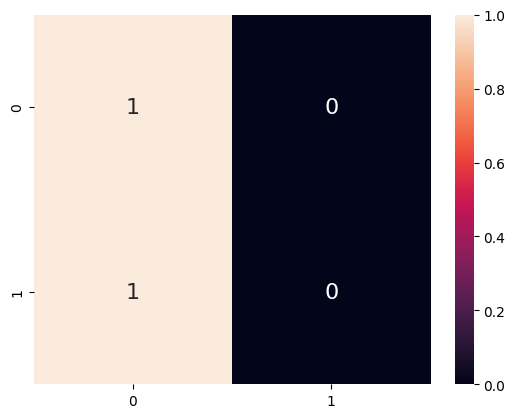

In [96]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(data=cm, annot=True, annot_kws={'fontsize':16})

Stulpelių svarba modeliui:
                Feature  Importance
0           dangosRusis    0.660828
6  neblaivusKaltininkai    0.575420
8      kelioApsvietimas    0.470263
3           dangosBukle    0.265702
9                 lytis    0.159825
2     kelioGatvesKreive    0.138144
5      leistinasGreitis    0.058447
4          meteoSalygos    0.018349
1            dataLaikas    0.005824
7   apsvaigeKaltininkai    0.002549


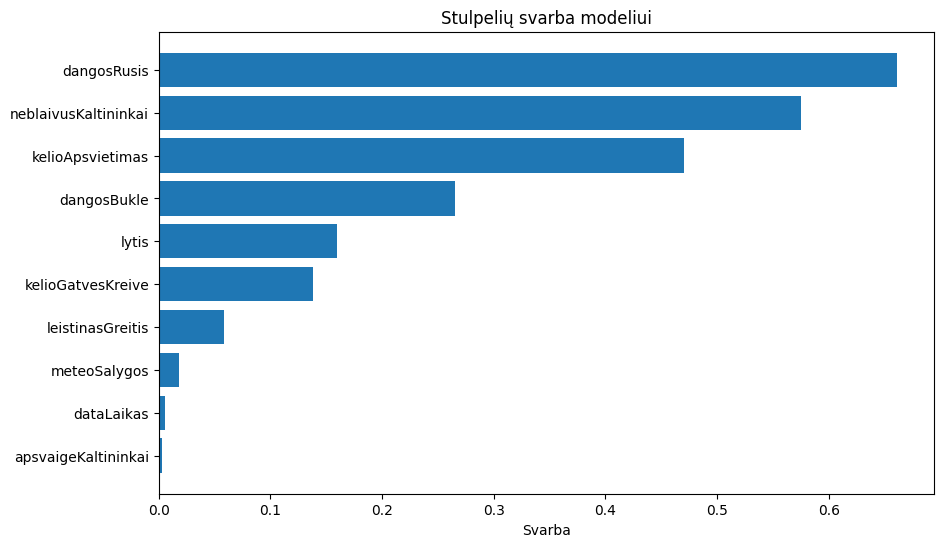

In [99]:
import pandas as pd
import numpy as np

# Sukuriame DataFrame su stulpelių svarba (koeficientais)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(clf.coef_[0])  # Naudojame absoliučias reikšmes, kad svarba būtų aiškesnė
})

# Rikiuojame pagal svarbą
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Spausdiname svarbiausius stulpelius
print("Stulpelių svarba modeliui:")
print(feature_importance)

# Galite vizualizuoti svarbą (neprivaloma)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], align='center')
plt.xlabel('Svarba')
plt.title('Stulpelių svarba modeliui')
plt.gca().invert_yaxis()  # Apverčiame ašį, kad svarbiausi stulpeliai būtų viršuje
plt.show()


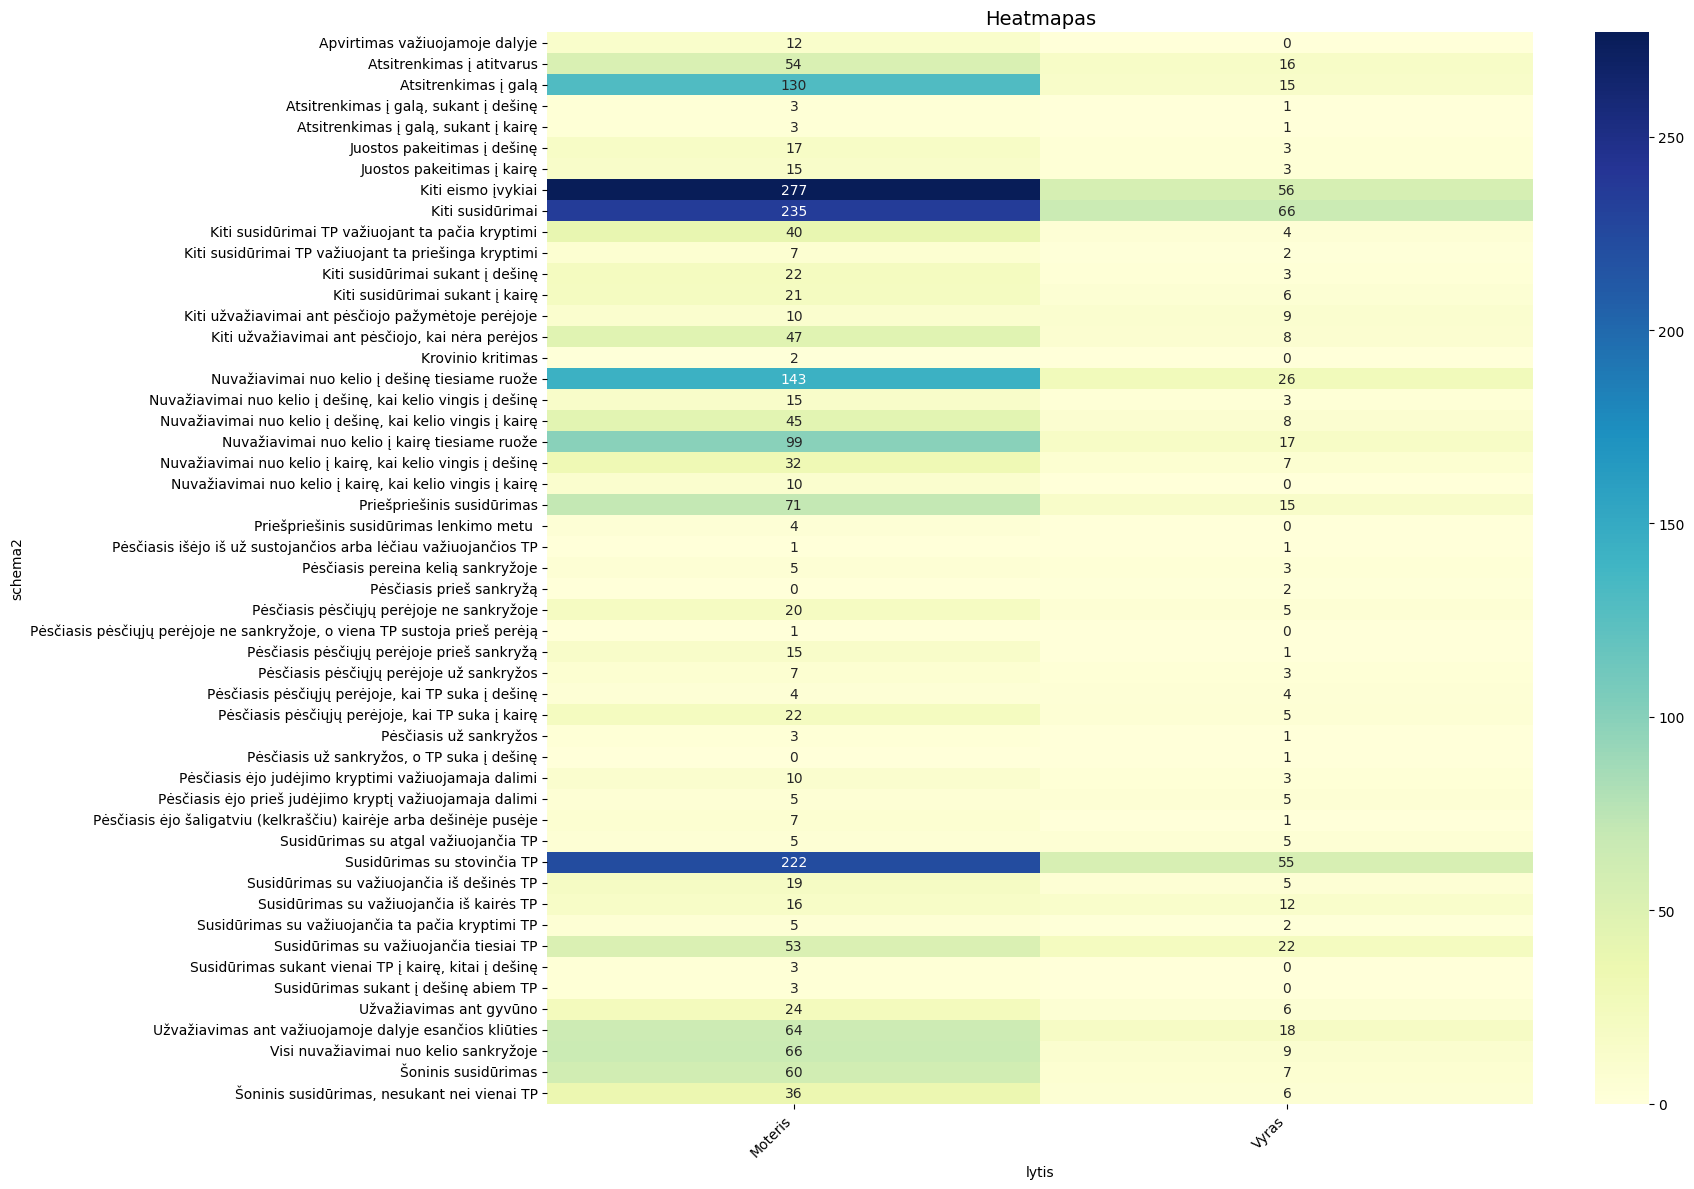

In [114]:

def extract_lytis_schema(df):
    schema_lytis_counts = df.groupby(['schema2', 'lytis']).size().unstack(fill_value=0)
    return schema_lytis_counts

# Gautas duomenis grupuojame pagal 'schema2' ir 'lytis'
lytis_schema_stats = extract_lytis_schema(df)


plt.figure(figsize=(18, 12))
sns.heatmap(lytis_schema_stats, annot=True, fmt="d", cmap="YlGnBu")

plt.title('Heatmapas', fontsize=14)
# plt.xlabel('Lytis (0 - Vyras, 1 - Moteris)', fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

